In [11]:
!pip install pyqt5

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import json
import time

import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation, FFMpegWriter
from IPython.display import display, HTML
import ipywidgets as widgets
from scipy.spatial.transform import Rotation

import mediapipe as mp

In [ ]:
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose


fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Choose the desired video codec (e.g., 'mp4v', 'xvid', 'MJPG')
output_file = 'testing.mp4'  # Specify the output video file name
frame_width = 640  # Specify the width of the frames in the output video
frame_height = 480  # Specify the height of the frames in the output video
frame_rate = 30.0  # Specify the frame rate of the output video

# Create a VideoWriter object
out = cv2.VideoWriter(output_file, fourcc, frame_rate, (frame_width, frame_height))


cap = cv2.VideoCapture(0)  # Change the index to use a different camera

raw_landmarks = []

# Initialize variables for FPS calculation
prev_time = time.time()
frame_count = 0
fps_graph = []
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Convert the BGR frame to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame_rgb.flags.writeable = False

        # Perform pose estimation
        results = pose.process(frame_rgb)

        # Extract the pose landmarks
        if results.pose_landmarks:
            raw_landmarks += [results.pose_landmarks]


        # Draw the pose landmarks on the frame
        mp_drawing.draw_landmarks(frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
        
        
        
        # Calculate the current FPS
        current_time = time.time()
        frame_count += 1
        fps = frame_count / (current_time - prev_time)

        # Add FPS text overlay to the frame
        fps_text = f'FPS: {fps:.2f}'
        fps_graph +=  [fps]
        
        
        # Calculate the position and size of the text overlay
        text_width, h = cv2.getTextSize(fps_text, cv2.FONT_HERSHEY_SIMPLEX, 1, 2)
        text_width = int(0.2 * frame_width)
        text_height = h
        text_pos = (frame_width - text_width - 10, frame_height - text_height - 10)

        # Add the FPS text to the frame
        cv2.putText(frame, fps_text, text_pos, cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        
        
        
        out.write(frame)
        cv2.imshow('MediaPipe Pose Estimation', frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break


cap.release()
out.release()
cv2.destroyAllWindows()

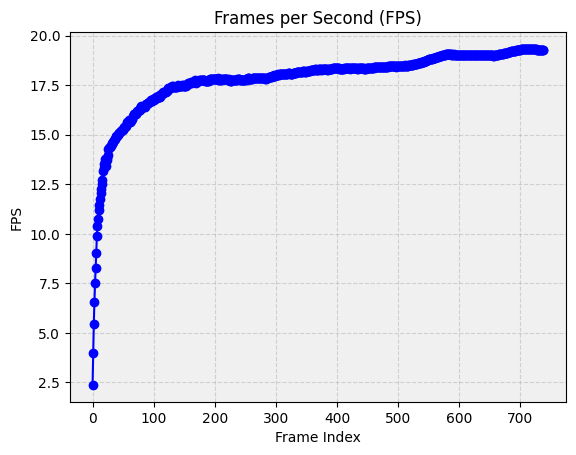

In [6]:
%matplotlib inline
frame_indices = range(len(fps_graph))
fig, ax = plt.subplots()
ax.plot(frame_indices, fps_graph, color='blue', marker='o', linestyle='-')
ax.set_xlabel('Frame Index')
ax.set_ylabel('FPS')
ax.set_title('Frames per Second (FPS)')
ax.grid(True, linestyle='--', alpha=0.5)
ax.set_facecolor('#f0f0f0')
plt.show()

In [10]:
cap.release()

In [65]:
!rm testing.webm

In [66]:
!ffmpeg -i testing.mp4 -c:v libvpx -c:a libvorbis testing.webm
!rm testing.mp4

ffmpeg version n6.0 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 13.1.1 (GCC) 20230429
  configuration: --prefix=/usr --disable-debug --disable-static --disable-stripping --enable-amf --enable-avisynth --enable-cuda-llvm --enable-lto --enable-fontconfig --enable-gmp --enable-gnutls --enable-gpl --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libdav1d --enable-libdrm --enable-libfreetype --enable-libfribidi --enable-libgsm --enable-libiec61883 --enable-libjack --enable-libjxl --enable-libmfx --enable-libmodplug --enable-libmp3lame --enable-libopencore_amrnb --enable-libopencore_amrwb --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librav1e --enable-librsvg --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtheora --enable-libv4l2 --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable

In [79]:
def parse_landmarks(landmarks):
    new_landmarks = []
    visibles = []
    for landmark in landmarks:
        new_landmarks += [[[p.x, p.y, p.z] for p in landmark.landmark]]
        visibles += [[p.visibility for p in landmark.landmark]]
    
    rotation_x = np.radians(1)  # rotation around x-axis (in radians)
    rotation_y = np.radians(90)  # rotation around y-axis (in radians)
    rotation_z = np.radians(1)  # rotation around z-axis (in radians)

    rot_matrix_x = np.array([
        [1, 0, 0],
        [0, np.cos(rotation_x), -np.sin(rotation_x)],
        [0, np.sin(rotation_x), np.cos(rotation_x)]
    ])

    rot_matrix_y = np.array([
        [np.cos(rotation_y), 0, np.sin(rotation_y)],
        [0, 1, 0],
        [-np.sin(rotation_y), 0, np.cos(rotation_y)]
    ])

    rot_matrix_z = np.array([
        [np.cos(rotation_z), -np.sin(rotation_z), 0],
        [np.sin(rotation_z), np.cos(rotation_z), 0],
        [0, 0, 1]
    ])

    # Apply rotation to each frame of landmarks
    rotated_landmarks_list = []
    for frame_landmarks in new_landmarks:
        frame_landmarks = np.array(frame_landmarks)
        rotated_landmarks = np.dot(rot_matrix_z, np.dot(rot_matrix_y, np.dot(rot_matrix_x, frame_landmarks.T))).T
        rotated_landmarks_list.append(rotated_landmarks.tolist())
    return np.array(new_landmarks), np.array(visibles)

In [80]:
landmarks, visibles = parse_landmarks(raw_landmarks)

In [81]:
axis = np.array([0, 1, 0]) 
angular_speed = 3
rotation_angle = np.deg2rad(angular_speed)

rotation = Rotation.from_rotvec(rotation_angle * axis)

In [82]:

def plot_person(index):
    global rotation_angle
    ax.clear()
    
    frame_final = landmarks[index]

    visibility = visibles[index]
    minimum_visibility = 0.5
    
    # Plot the 3D body lines
    for connection in mp_pose.POSE_CONNECTIONS:
        joint1 = connection[0]
        joint2 = connection[1]
        if visibility[joint1] > minimum_visibility and visibility[joint2] > minimum_visibility:
            x = [frame_final[joint1][0], frame_final[joint2][0]]
            y = [frame_final[joint1][1], frame_final[joint2][1]]
            z = [frame_final[joint1][2], frame_final[joint2][2]]

            ax.plot(x, y, z, c='r')
        
    # Plot the 3D body landmarks as dots
    x = [landmark[0] for i, landmark in enumerate(frame_final) if visibility[i] > minimum_visibility]
    y = [landmark[1] for i, landmark in enumerate(frame_final) if visibility[i] > minimum_visibility]
    z = [landmark[2] for i, landmark in enumerate(frame_final) if visibility[i] > minimum_visibility]
    ax.scatter(x, y, z, c='b')
    
    # Set the plot limits
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    
    return ax

<Axes3D: >

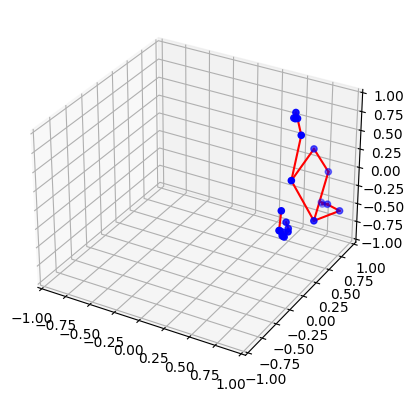

In [83]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plot_person(80)

In [84]:
landmarks.shape

(131, 33, 3)

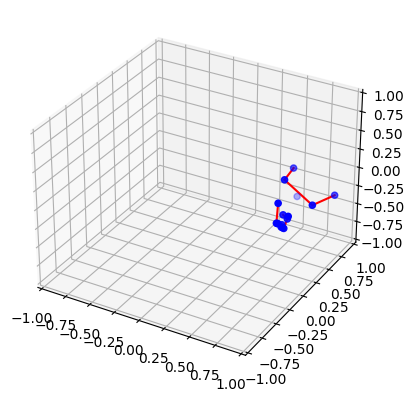

In [85]:
plt.rcParams['animation.embed_limit'] = 50.0  # Increase the embedding limit to 50 MB

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
def update(index):
    ax.cla()
    plot_person(index)

# Create the animation
animation = FuncAnimation(fig, update, frames=len(landmarks), interval=15)

# Display the animation in Jupyter Notebook

In [60]:
# Set up the video writer
writer = FFMpegWriter(fps=30, metadata=dict(artist='Me'), bitrate=1800)

# Save the animation as a video
animation.save('animation.mp4', writer=writer)

In [61]:
!ls

'Processing some landmark.ipynb'   mediapipe_posture_estimator
 README.md			   nohup.out
 animation.mp4			   testing.webm
 media				   yolov7_posture_estimator


In [62]:
widget1 = widgets.Video.from_file('testing.webm')
widget2 = widgets.Video.from_file('animation.mp4')

# Create the custom box layout with fixed width
box_layout = widgets.Layout(width='800px')

# Create the box container and add the videos
box = widgets.Box(children=[widget1, widget2], layout=box_layout)

# Display the box container
display(box)

Box(children=(Video(value=b'\x1aE\xdf\xa3\x9fB\x86\x81\x01B\xf7\x81\x01B\xf2\x81\x04B\xf3\x81\x08B\x82\x84webm…

In [25]:
!mkdir media
!ffmpeg -i testing.webm media/testing.gif
!ffmpeg -i animation.mp4 media/animation.gif

ffmpeg version n6.0 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 13.1.1 (GCC) 20230429
  configuration: --prefix=/usr --disable-debug --disable-static --disable-stripping --enable-amf --enable-avisynth --enable-cuda-llvm --enable-lto --enable-fontconfig --enable-gmp --enable-gnutls --enable-gpl --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libdav1d --enable-libdrm --enable-libfreetype --enable-libfribidi --enable-libgsm --enable-libiec61883 --enable-libjack --enable-libjxl --enable-libmfx --enable-libmodplug --enable-libmp3lame --enable-libopencore_amrnb --enable-libopencore_amrwb --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librav1e --enable-librsvg --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtheora --enable-libv4l2 --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable

frame=  153 fps=135 q=-0.0 Lsize=    9052kB time=00:00:05.07 bitrate=14625.8kbits/s speed=4.48x    
video:9052kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000216%
ffmpeg version n6.0 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 13.1.1 (GCC) 20230429
  configuration: --prefix=/usr --disable-debug --disable-static --disable-stripping --enable-amf --enable-avisynth --enable-cuda-llvm --enable-lto --enable-fontconfig --enable-gmp --enable-gnutls --enable-gpl --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libdav1d --enable-libdrm --enable-libfreetype --enable-libfribidi --enable-libgsm --enable-libiec61883 --enable-libjack --enable-libjxl --enable-libmfx --enable-libmodplug --enable-libmp3lame --enable-libopencore_amrnb --enable-libopencore_amrwb --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librav1e --enable-librsvg --enable-libsoxr --enable-libspeex -